In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import zhinst.utils

In [26]:
class DFRT_setup:
    
    def __init__(self,device_id):
        self.device_id = device_id
        self.device = 'data has not loaded'
        self.daq = 'data has not loaded'
        self.props ='data has not loaded'
        self.sweep = 'not active'
        self.samples_sweep ='data has not loaded'
        
    def discov_device(self, disa_all_output = False):
        # Settings
        apilevel_example = 6  # The API level supported by this example.
        err_msg = "This example can only be ran on either a UHFAWG, UHFQA or a UHF with the AWG option enabled."
        # Call a zhinst utility function that returns:
        # - an API session `daq` in order to communicate with devices via the data server.
        # - the device ID string that specifies the device branch in the server's node hierarchy.
        # - the device's discovery properties.
        (self.daq, self.device, self.props) = zhinst.utils.create_api_session(
            self.device_id, apilevel_example, required_devtype="UHF", required_options=["AWG"],
            required_err_msg=err_msg
        )
        
        zhinst.utils.api_server_version_check(self.daq)
        
        if disa_all_output:
            # Create a base configuration: Disable all available outputs, awgs, demods, scopes,...
            zhinst.utils.disable_everything(self.daq, self.device)
            print('Disable all available outputs, awgs, demods, scopes,...')
            
    def sweep_frq(self,start=300e3,stop=450e3,points=400,amplitude=0.5, do_plot=True):
        out_channel = 0
        out_mixer_channel = zhinst.utils.default_output_mixer_channel(self.props)
        in_channel = 0
        demod_index = 0
        osc_index = 0
        demod_rate = 10e3
        time_constant = 0.01
        exp_setting = [
            ["/%s/sigins/%d/ac" % (self.device, in_channel), 1],
            ["/%s/sigins/%d/range" % (self.device, in_channel), 4 * amplitude],
            ["/%s/demods/%d/enable" % (self.device, demod_index), 1],
            ["/%s/demods/%d/rate" % (self.device, demod_index), demod_rate],
            ["/%s/demods/%d/adcselect" % (self.device, demod_index), in_channel],
            ["/%s/demods/%d/order" % (self.device, demod_index), 4],
            ["/%s/demods/%d/timeconstant" % (self.device, demod_index), time_constant],
            ["/%s/demods/%d/oscselect" % (self.device, demod_index), osc_index],
            ["/%s/demods/%d/harmonic" % (self.device, demod_index), 1],
            ["/%s/sigouts/%d/on" % (self.device, out_channel), 1],
            ["/%s/sigouts/%d/enables/%d" % (self.device, out_channel, out_mixer_channel), 1],
            ["/%s/sigouts/%d/range" % (self.device, out_channel), 1],
            ["/%s/sigouts/%d/amplitudes/%d" % (self.device, out_channel, out_mixer_channel), amplitude],
        ]
        self.daq.set(exp_setting)

        # Perform a global synchronisation between the device and the data server:
        # Ensure that 1. the settings have taken effect on the device before issuing
        # the poll() command and 2. clear the API's data buffers.
        self.daq.sync()

        # Create an instance of the Sweeper Module (ziDAQSweeper class).
        sweeper = self.daq.sweep()

        # Configure the Sweeper Module's parameters.
        # Set the device that will be used for the sweep - this parameter must be set.
        sweeper.set("device", self.device)
        
        # Specify the `gridnode`: The instrument node that we will sweep, the device
        # setting corresponding to this node path will be changed by the sweeper.
        osc_index = 0
        sweeper.set("gridnode", "oscs/%d/freq" % osc_index)
        # Set the `start` and `stop` values of the gridnode value interval we will use in the sweep.
        sweeper.set("start", start)
        sweeper.set("stop", stop)
        # Set the number of points to use for the sweep, the number of gridnode
        # setting values will use in the interval (`start`, `stop`).
        samplecount = points
        sweeper.set("samplecount", samplecount)
        # Specify logarithmic spacing for the values in the sweep interval.
        sweeper.set("xmapping", 1)
        # Automatically control the demodulator bandwidth/time constants used.
        # 0=manual, 1=fixed, 2=auto
        # Note: to use manual and fixed, bandwidth has to be set to a value > 0.
        sweeper.set("bandwidthcontrol", 2)
        # Sets the bandwidth overlap mode (default 0). If enabled, the bandwidth of
        # a sweep point may overlap with the frequency of neighboring sweep
        # points. The effective bandwidth is only limited by the maximal bandwidth
        # setting and omega suppression. As a result, the bandwidth is independent
        # of the number of sweep points. For frequency response analysis bandwidth
        # overlap should be enabled to achieve maximal sweep speed (default: 0). 0 =
        # Disable, 1 = Enable.
        sweeper.set("bandwidthoverlap", 0)

        # Sequential scanning mode (as opposed to binary or bidirectional).
        sweeper.set("scan", 0)
        # Specify the number of sweeps to perform back-to-back.
        loopcount = 1
        sweeper.set("loopcount", loopcount)
        # We don't require a fixed settling/time since there is no DUT
        # involved in this example's setup (only a simple feedback cable), so we set
        # this to zero. We need only wait for the filter response to settle,
        # specified via settling/inaccuracy.
        sweeper.set("settling/time", 0)
        # The settling/inaccuracy' parameter defines the settling time the
        # sweeper should wait before changing a sweep parameter and recording the next
        # sweep data point. The settling time is calculated from the specified
        # proportion of a step response function that should remain. The value
        # provided here, 0.001, is appropriate for fast and reasonably accurate
        # amplitude measurements. For precise noise measurements it should be set to
        # ~100n.
        # Note: The actual time the sweeper waits before recording data is the maximum
        # time specified by settling/time and defined by
        # settling/inaccuracy.
        sweeper.set("settling/inaccuracy", 0.001)
        # Set the minimum time to record and average data to 10 demodulator
        # filter time constants.
        sweeper.set("averaging/tc", 10)
        # Minimal number of samples that we want to record and average is 100. Note,
        # the number of samples used for averaging will be the maximum number of
        # samples specified by either averaging/tc or averaging/sample.
        sweeper.set("averaging/sample", 10)

        # Now subscribe to the nodes from which data will be recorded. Note, this is
        # not the subscribe from ziDAQServer; it is a Module subscribe. The Sweeper
        # Module needs to subscribe to the nodes it will return data for.x
        demod_index = 0
        path = "/%s/demods/%d/sample" % (self.device, demod_index)
        sweeper.subscribe(path)

        # Start the Sweeper's thread.
        sweeper.execute()

        start = time.time()
        timeout = 60  # [s]
        print("Will perform", loopcount, "frequency sweeps...")
        while not sweeper.finished():  # Wait until the sweep is complete, with timeout.
            time.sleep(0.2)
            progress = sweeper.progress()
            print(f"Individual sweep progress: {progress[0]:.2%}.", end="\r")
            # Here we could read intermediate data via:
            # data = sweeper.read(True)...
            # and process it while the sweep is completing.
            # if device in data:
            # ...
            if (time.time() - start) > timeout:
                # If for some reason the sweep is blocking, force the end of the
                # measurement.
                print("\nSweep still not finished, forcing finish...")
                self.daq.sync()
                sweeper.finish()
        print("")
        
        # Read the sweep data. This command can also be executed whilst sweeping
        # (before finished() is True), in this case sweep data up to that time point
        # is returned. It's still necessary still need to issue read() at the end to
        # fetch the rest.
        return_flat_dict = True
        data = sweeper.read(return_flat_dict)
        sweeper.unsubscribe(path)
        
        # Check the dictionary returned is non-empty.
        assert data, "read() returned an empty data dictionary, did you subscribe to any paths?"
        # Note: data could be empty if no data arrived, e.g., if the demods were
        # disabled or had rate 0.
        assert path in data, "No sweep data in data dictionary: it has no key '%s'" % path
        samples = data[path]
        print("Returned sweeper data contains", len(samples), "sweeps.")
        assert len(samples) == loopcount, "The sweeper returned an unexpected number of sweeps: `%d`. Expected: `%d`." % (
            len(samples),
            loopcount,
        )

        if do_plot:
            _, (ax1, ax2) = plt.subplots(2, 1)

            for sample in samples:
                frequency = sample[0]["frequency"]
                R = np.abs(sample[0]["x"] + 1j * sample[0]["y"])
                phi = np.angle(sample[0]["x"] + 1j * sample[0]["y"])
                ax1.plot(frequency, R, 'b')
                ax2.plot(frequency, phi, 'b')
            ax1.set_title("Results of %d sweeps." % len(samples))
            ax1.grid()
            ax1.set_ylabel(r"Amp ($V_\mathrm{RMS}$)")
            ax1.autoscale()

            ax2.grid()
            ax2.set_xlabel("Frequency ($Hz$)")
            ax2.set_ylabel(r"Phase (radians)")
            ax2.autoscale()

            plt.draw()
            plt.show()
            
        self.samples_sweep = samples
        R = np.abs(sample[0]["x"] + 1j * sample[0]["y"])
        print('frequency of the maximum amplitude = '+str(sample[0]["frequency"][np.argmax(R, axis=0)]))
        
    def setMOD(self, center_freq = 381e3, bw = 5e3,amplitude = 0.75 ):
        
        self.daq.setDouble("/%s/oscs/0/freq" % self.device, center_freq)
        self.daq.setInt("/%s/mods/0/sidebands/0/oscselect" % self.device,1)
        self.daq.setDouble("/%s/oscs/1/freq" % self.device,bw)
        self.daq.setDouble("/%s/mods/0/sidebands/0/amplitude" % self.device,amplitude)
        
        #Enable the modulation amplitude
        self.daq.setInt("/%s/mods/0/sidebands/0/enable" % self.device,1)
        
        #Enable the MOD
        self.daq.setInt("/%s/mods/0/enable" % self.device,1)
        
        #Disble the carriers amplitude
        self.daq.setInt("/%s/mods/0/carrier/enable" % self.device,0)
        

        
    def setAU(self):
        
        self.daq.setInt("/%s/aupolars/0/ops/1/demodselect" % self.device,1)  
        self.daq.setDouble("/%s/aupolars/0/ops/1/scale"% self.device,1)
        
        self.daq.setInt("/%s/aupolars/0/ops/0/demodselect" % self.device,2)
        self.daq.setDouble("/%s/aupolars/0/ops/0/scale"% self.device,-1)
        
        
    def sweep_frqMOD(self,start=300e3,stop=450e3,points=400,amplitude=0.5,amplitude_mod=0.5, do_plot=True):
        out_channel = 0
        out_mixer_channel = zhinst.utils.default_output_mixer_channel(self.props)
        in_channel = 0
        demod_index = 0
        demod_index_lowSB = 1
        demod_index_highSB = 2
        osc_index = 0
        demod_rate = 10e3
        time_constant = 0.01
        exp_setting = [
            ["/%s/sigins/%d/ac" % (self.device, in_channel), 1],
            ["/%s/sigins/%d/range" % (self.device, in_channel), 4 * amplitude],
            ["/%s/demods/%d/enable" % (self.device, demod_index), 1],
            ["/%s/demods/%d/enable" % (self.device, demod_index_lowSB), 1],
            ["/%s/demods/%d/enable" % (self.device, demod_index_highSB), 1],
            ["/%s/demods/%d/rate" % (self.device, demod_index), demod_rate],
            ["/%s/demods/%d/rate" % (self.device, demod_index_lowSB), demod_rate],
            ["/%s/demods/%d/rate" % (self.device, demod_index_highSB), demod_rate],
            ["/%s/demods/%d/adcselect" % (self.device, demod_index), in_channel],
            ["/%s/demods/%d/adcselect" % (self.device, demod_index_lowSB), in_channel],
            ["/%s/demods/%d/adcselect" % (self.device, demod_index_highSB), in_channel],
            ["/%s/demods/%d/order" % (self.device, demod_index), 4],
            ["/%s/demods/%d/timeconstant" % (self.device, demod_index), time_constant],
            ["/%s/demods/%d/oscselect" % (self.device, demod_index), osc_index],
            ["/%s/demods/%d/harmonic" % (self.device, demod_index), 1],
            ["/%s/sigouts/%d/on" % (self.device, out_channel), 1],
            ["/%s/sigouts/%d/enables/%d" % (self.device, out_channel, out_mixer_channel), 1],
            ["/%s/sigouts/%d/range" % (self.device, out_channel), 1.5],
            ["/%s/sigouts/%d/amplitudes/%d" % (self.device, out_channel, out_mixer_channel), amplitude],
            ["/%s/sigouts/%d/amplitudes/%d" % (self.device, 1, 1), amplitude_mod],
            ["/%s/sigouts/%d/amplitudes/%d" % (self.device, 2, 2), amplitude_mod],   
        ]
        self.daq.set(exp_setting)
        
        
        # Perform a global synchronisation between the device and the data server:
        # Ensure that 1. the settings have taken effect on the device before issuing
        # the poll() command and 2. clear the API's data buffers.
        self.daq.sync()

        # Create an instance of the Sweeper Module (ziDAQSweeper class).
        sweeper = self.daq.sweep()

        # Configure the Sweeper Module's parameters.
        # Set the device that will be used for the sweep - this parameter must be set.
        sweeper.set("device", self.device)
        
        # Specify the `gridnode`: The instrument node that we will sweep, the device
        # setting corresponding to this node path will be changed by the sweeper.
        osc_index = 0
        sweeper.set("gridnode", "oscs/%d/freq" % osc_index)
        # Set the `start` and `stop` values of the gridnode value interval we will use in the sweep.
        sweeper.set("start", start)
        sweeper.set("stop", stop)
        # Set the number of points to use for the sweep, the number of gridnode
        # setting values will use in the interval (`start`, `stop`).
        samplecount = points
        sweeper.set("samplecount", samplecount)
        # Specify logarithmic spacing for the values in the sweep interval.
        sweeper.set("xmapping", 1)
        # Automatically control the demodulator bandwidth/time constants used.
        # 0=manual, 1=fixed, 2=auto
        # Note: to use manual and fixed, bandwidth has to be set to a value > 0.
        sweeper.set("bandwidthcontrol", 2)
        # Sets the bandwidth overlap mode (default 0). If enabled, the bandwidth of
        # a sweep point may overlap with the frequency of neighboring sweep
        # points. The effective bandwidth is only limited by the maximal bandwidth
        # setting and omega suppression. As a result, the bandwidth is independent
        # of the number of sweep points. For frequency response analysis bandwidth
        # overlap should be enabled to achieve maximal sweep speed (default: 0). 0 =
        # Disable, 1 = Enable.
        sweeper.set("bandwidthoverlap", 0)

        # Sequential scanning mode (as opposed to binary or bidirectional).
        sweeper.set("scan", 0)
        # Specify the number of sweeps to perform back-to-back.
        loopcount = 1
        sweeper.set("loopcount", loopcount)
        # We don't require a fixed settling/time since there is no DUT
        # involved in this example's setup (only a simple feedback cable), so we set
        # this to zero. We need only wait for the filter response to settle,
        # specified via settling/inaccuracy.
        sweeper.set("settling/time", 0)
        # The settling/inaccuracy' parameter defines the settling time the
        # sweeper should wait before changing a sweep parameter and recording the next
        # sweep data point. The settling time is calculated from the specified
        # proportion of a step response function that should remain. The value
        # provided here, 0.001, is appropriate for fast and reasonably accurate
        # amplitude measurements. For precise noise measurements it should be set to
        # ~100n.
        # Note: The actual time the sweeper waits before recording data is the maximum
        # time specified by settling/time and defined by
        # settling/inaccuracy.
        sweeper.set("settling/inaccuracy", 0.001)
        # Set the minimum time to record and average data to 10 demodulator
        # filter time constants.
        sweeper.set("averaging/tc", 10)
        # Minimal number of samples that we want to record and average is 100. Note,
        # the number of samples used for averaging will be the maximum number of
        # samples specified by either averaging/tc or averaging/sample.
        sweeper.set("averaging/sample", 10)

        # Now subscribe to the nodes from which data will be recorded. Note, this is
        # not the subscribe from ziDAQServer; it is a Module subscribe. The Sweeper
        # Module needs to subscribe to the nodes it will return data for.x
        demod_index = 0
        path = "/%s/demods/%d/sample" % (self.device, demod_index)
        sweeper.subscribe(path)
        
        #Subscribe demod2
        demod_index_lowSB = 1
        path_lowSB = "/%s/demods/%d/sample" % (self.device, demod_index_lowSB)
        sweeper.subscribe(path_lowSB)
        
        #Subscribe demod3
        demod_index_highSB = 2
        path_highSB = "/%s/demods/%d/sample" % (self.device, demod_index_highSB)
        sweeper.subscribe(path_highSB)
        

        # Start the Sweeper's thread.
        sweeper.execute()
        
        start = time.time()
        timeout = 60  # [s]
        print("Will perform", loopcount, "frequency sweeps...")
        while not sweeper.finished():  # Wait until the sweep is complete, with timeout.
            time.sleep(0.2)
            progress = sweeper.progress()
            print(f"Individual sweep progress: {progress[0]:.2%}.", end="\r")
            # Here we could read intermediate data via:
            # data = sweeper.read(True)...
            # and process it while the sweep is completing.
            # if device in data:
            # ...
            if (time.time() - start) > timeout:
                # If for some reason the sweep is blocking, force the end of the
                # measurement.
                print("\nSweep still not finished, time-out")
                self.daq.sync()
                sweeper.finish()
        print("")
        
        # Read the sweep data. This command can also be executed whilst sweeping
        # (before finished() is True), in this case sweep data up to that time point
        # is returned. It's still necessary still need to issue read() at the end to
        # fetch the rest.
        return_flat_dict = True
        data = sweeper.read(return_flat_dict)
        sweeper.unsubscribe(path)
        
        # Check the dictionary returned is non-empty.
        assert data, "read() returned an empty data dictionary, did you subscribe to any paths?"
        # Note: data could be empty if no data arrived, e.g., if the demods were
        # disabled or had rate 0.
        assert path in data, "No sweep data in data dictionary: it has no key '%s'" % path
        samples = data[path]
        print("Returned sweeper data contains", len(samples), "sweeps.")
        assert len(samples) == loopcount, "The sweeper returned an unexpected number of sweeps: `%d`. Expected: `%d`." % (
            len(samples),
            loopcount,
        )

        if do_plot:
            _, (ax1, ax2) = plt.subplots(2, 1)

            for sample in samples:
                frequency = sample[0]["frequency"]
                R = np.abs(sample[0]["x"] + 1j * sample[0]["y"])
                phi = np.angle(sample[0]["x"] + 1j * sample[0]["y"])
                ax1.plot(frequency, R, 'b')
                ax2.plot(frequency, phi, 'b')
            ax1.set_title("Results of %d sweeps." % len(samples))
            ax1.grid()
            ax1.set_ylabel(r"Amp ($V_\mathrm{RMS}$)")
            ax1.autoscale()

            ax2.grid()
            ax2.set_xlabel("Frequency ($Hz$)")
            ax2.set_ylabel(r"Phase (radians)")
            ax2.autoscale()

            plt.draw()
            plt.show()
            
        self.samples_sweep = samples
        R = np.abs(sample[0]["x"] + 1j * sample[0]["y"])
        print('frequency of the maximum amplitude = '+str(sample[0]["frequency"][np.argmax(R, axis=0)]))

# Device connection

In [36]:
A1=DFRT_setup('Dev2451')
A1.discov_device(disa_all_output = True)

Discovered device `dev2451`: UHFLI with options MF, PID, MOD, AWG, DIG, BOX, CNT.
Creating an API session for device `dev2451` on `127.0.0.1`, `8004` with apilevel `6`.
Disable all available outputs, awgs, demods, scopes,...


#  Seek the contact resonance frequency
 To obtain the center frequency,the frequency sweeping in expected frequency range must be done   

Will perform 1 frequency sweeps...
Individual sweep progress: 100.00%.
Returned sweeper data contains 1 sweeps.


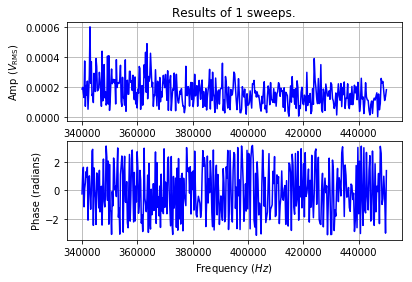

frequency of the maximum amplitude = 342878.36109569983


In [40]:
A1.sweep_frq(start=340e3,stop=450e3,points=400,amplitude=1,do_plot=True)

#  Double-sideband Modulation
Double-sideband Suppressed-carrier (DSB-SC) modulation is an amplitude modulation, which consists only of the two symmetrical sidebands and no carrier band.

ref. Info. :https://blogs.zhinst.com/sadik/2013/08/dsb-sc/

Half of the FWHM is usually a good value for the modulation frequency in the MOD module

Will perform 1 frequency sweeps...
Individual sweep progress: 100.00%.
Returned sweeper data contains 1 sweeps.


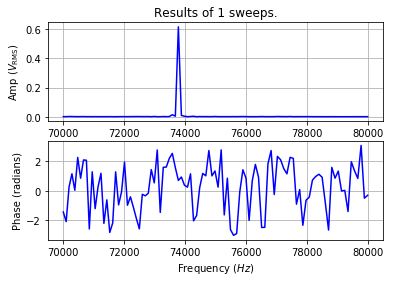

frequency of the maximum amplitude = 73780.7987313488


In [39]:
A1.setMOD(center_freq = 73e3, bw = 3e3,amplitude = 0.8 )
A1.sweep_frqMOD(start=70e3,stop=80e3,points=100)

# PID setup
https://blogs.zhinst.com/romain/dfrt-revisited-from-feedback-optimization-to-full-daq-acquisition/

In [ ]:
A1.setAU()

In [24]:
A1.setMOD(center_freq = 70e3, bw = 1e3,amplitude = 0.2)